# Dependencies

In [5]:
pacman::p_load(
    patchwork,
    igraph, graphlayouts,
    dplyr, ggplot2, GUniFrac, ggsignif,
    lsmeans, factoextra
)


# Functions

In [6]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

In [7]:
cohort_comp.fx <- function(comp_out_sep, sampletype, cycle) {
    compout_sampletype <- comp_out_sep[grepl(sampletype, comp_out_sep$basename), ]
    compout_sampletype <- compout_sampletype[grepl(cycle, compout_sampletype$basename), ]
    emerson_sep <- comp_out_sep[grepl("Emerson", comp_out_sep$PatientDerived_Nodes), ]

    compout_int_emerson <- rbind(emerson_sep, compout_sampletype)

    mytab <- as.data.frame.matrix(table(compout_int_emerson$cohort, compout_int_emerson$Component_id))
    cohort_comp <- as.data.frame(t(mytab))
    # length(unique(compout_int_emerson$Component_id))
    cohort_comp$grp <- NA
    # if AdultEmeson > 0 and others = 0, grp = Adult
    cohort_comp$grp[cohort_comp$AdultEmerson > 0 & cohort_comp$ChildEmerson == 0 &
        cohort_comp$Leukemia == 0 & cohort_comp$Lymphoma == 0 &
        cohort_comp$Solidtumors == 0 & cohort_comp$`T-cellmalignancies` == 0] <- "Adult"

    cohort_comp$grp[cohort_comp$AdultEmerson == 0 & cohort_comp$ChildEmerson > 0 &
        cohort_comp$Leukemia == 0 & cohort_comp$Lymphoma == 0 &
        cohort_comp$Solidtumors == 0 & cohort_comp$`T-cellmalignancies` == 0] <- "Child"

    cohort_comp$grp[cohort_comp$AdultEmerson == 0 & cohort_comp$ChildEmerson == 0 &
        cohort_comp$Leukemia > 0 & cohort_comp$Lymphoma == 0 &
        cohort_comp$Solidtumors == 0 & cohort_comp$`T-cellmalignancies` == 0] <- "Leukemia"

    cohort_comp$grp[cohort_comp$AdultEmerson == 0 & cohort_comp$ChildEmerson == 0 &
        cohort_comp$Leukemia == 0 & cohort_comp$Lymphoma > 0 &
        cohort_comp$Solidtumors == 0 & cohort_comp$`T-cellmalignancies` == 0] <- "Lymphoma"

    cohort_comp$grp[cohort_comp$AdultEmerson == 0 & cohort_comp$ChildEmerson == 0 &
        cohort_comp$Leukemia == 0 & cohort_comp$Lymphoma == 0 &
        cohort_comp$Solidtumors > 0 & cohort_comp$`T-cellmalignancies` == 0] <- "Solid"

    cohort_comp$grp[cohort_comp$AdultEmerson == 0 & cohort_comp$ChildEmerson == 0 &
        cohort_comp$Leukemia == 0 & cohort_comp$Lymphoma == 0 &
        cohort_comp$Solidtumors == 0 & cohort_comp$`T-cellmalignancies` > 0] <- "TcellMalig"

    healthies <- cohort_comp$AdultEmerson == 0 & cohort_comp$ChildEmerson == 0
    cancers <- rowSums(cohort_comp[, c("Leukemia", "Lymphoma", "Solidtumors", "T-cellmalignancies")] > 0) >= 2
    cohort_comp$grp[healthies & cancers] <- "Cancer"
    healthies <- cohort_comp$AdultEmerson > 0 | cohort_comp$ChildEmerson > 0
    cancers <- rowSums(cohort_comp[, c(
        "Leukemia", "Lymphoma",
        "Solidtumors", "T-cellmalignancies"
    )] > 0) >= 1
    cohort_comp$grp[healthies & cancers] <- "Common"
    cohort_comp$grp[is.na(cohort_comp$grp)] <- "Healthy"
    return(cohort_comp)
    # table(cohort_comp$grp)
}


In [8]:
comp_frac.fx <- function(comp_out_sep, sampletype, cycle) {

    compout_sampletype <- comp_out_sep[grepl(sampletype, comp_out_sep$basename), ]
    compout_sampletype_cycle <- compout_sampletype[grepl(cycle, compout_sampletype$basename), ]
    emerson_sep <- comp_out_sep[grepl("Emerson", comp_out_sep$PatientDerived_Nodes), ]

    compout_int_emerson <- rbind(emerson_sep, compout_sampletype_cycle)

    pat_tab <- as.data.frame.matrix(table(compout_int_emerson$Patient, compout_int_emerson$cohort))
    tail(pat_tab)
    pat_tab$cohort <- NA
    pat_tab$cohort <- compout_int_emerson$cohort[match(rownames(pat_tab), compout_int_emerson$Patient)]
    
    pat_tab$total <- NA
    mycols <- c("CMV", "EBV", "HPV", "HCV", "HomoSapiens", "MCPyV", "Influenca", "tuberculosis", "pneumoniae")
    for (a in mycols) {
        pat_tab[[a]] <- NA
    }

    for (i in 1:nrow(pat_tab)) {
        pt <- rownames(pat_tab)[i]
        mycomppt <- compout_int_emerson[compout_int_emerson$Patient == pt, ]
        pat_tab$total[i] <- sum(mycomppt$cloneCount) # all clones incluuding those in common components

        # mycomppt <- mycomppt[ !mycomppt$Component_id %in% commoncomps,]
        # print(table(mycomppt$Component_id))
        for (a in c("CMV", "EBV", "HPV", "HCV", "HomoSapiens", "MCPyV", "Influenca", "tuberculosis", "pneumoniae")) {
            pat_tab[[a]][i] <- sum(mycomppt$cloneCount[grepl(a, mycomppt$Component_specificity)], na.rm = T)
        }
    }
    pat_tab[, mycols] <- pat_tab[, mycols] / pat_tab$total

    return(pat_tab)
}


# Paths

In [9]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [10]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/analysis/GLIPH/run_gliph/"

# Main

Cleanup int components

In [11]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [12]:
#remove those samples that we did not have the TCRseq data for
meta_div <- meta_div[!is.na(meta_div$TRB),]

In [13]:
meta_div[ meta_div$Patient == "CHP_414",]

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
776,CHP_414_01,CHP_414,X01,0.0,0.00,1,HB,0.0,0,NA,...,5.670,0.023,4.932,4.932,0.027,CHP_414-01_PBMC-DNA,remaining_batch_3_4May2021/mixcr/clones/CLONES_TRBCHP_414-01_PBMC-DNA.txt,PBMC,CHP,0.7534298
777,CHP_414_02,CHP_414,X02,0.0,802.76,1,HB,0.0,0,NA,...,595.457,1.378,503.215,506.518,1.961,CHP_414-02-PBMC-DNA,batch13_26Aug2020/mixcr/clones/CLONES_TRBCHP_414-02-PBMC-DNA.txt,PBMC,CHP,2.7726480
778,CHP_414_03,CHP_414,X03,0.8,73.80,1,HB,0.8,2525,312,...,377.849,0.674,319.849,320.709,1.023,CHP_414-03_PBMC-DNA,remaining_batch_3_4May2021/mixcr/clones/CLONES_TRBCHP_414-03_PBMC-DNA.txt,PBMC,CHP,2.5763978
270,CHP_414_01,CHP_414,X01,0.0,0.00,1,HB,0.0,0,NA,...,7.899,0.096,6.215,6.222,0.107,CHP_414-01_cfDNA,remaining_batch_4_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_414-01_cfDNA.txt,cfDNA,CHP,0.8970220
271,CHP_414_02,CHP_414,X02,0.0,802.76,1,HB,0.0,0,NA,...,3.637,0.046,3.155,3.158,0.059,CHP_414-02_cfDNA,remaining_batch_3_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_414-02_cfDNA.txt,cfDNA,CHP,0.5603849
272,CHP_414_03,CHP_414,X03,0.8,73.80,1,HB,0.8,2525,312,...,6.678,0.049,5.542,5.544,0.055,CHP_414-03_cfDNA,remaining_batch_3_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_414-03_cfDNA.txt,cfDNA,CHP,0.8245163


In [7]:
ls()

[1] "addjurkat.fx"            "age_pal"                
 [3] "align_plots1"            "calculate_delta.fx"     
 [5] "cohort_col"              "cycle_col"              
 [7] "datapath"                "delta_basespiderplot.fx"
 [9] "gitpath"                 "group_col"              
[11] "h4hpath"                 "histdenp"               
[13] "histp"                   "lsmeans_df.fx"          
[15] "manifestpath"            "message_parallel"       
[17] "meta_div"                "myaxis"                 
[19] "myplot"                  "plotpath"               
[21] "round_and_format"        "safe_mclapply"          
[23] "sampletags_columns"      "text_matrix"            
[25] "toString_onefle.fx"      "type_col"

In [7]:
tmp <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_v5_cleaned.rds"))

In [8]:
tmp$cdr3_sample <- paste(tmp$TcRb, tmp$Sample, sep = "_")

In [9]:
components <- read.table(paste0(datapath, "GLIPH/component_stats_intercept_cdr3_gliph2.csv"), sep = ",", header = T)

In [10]:
int_all <- readr::read_rds(file = paste0(datapath, "capTCRseq/INT_all_gliph_input_v2.rds"))

In [11]:
# remove space
int_all$`subject:condition` <- gsub(" ", "", int_all$`subject:condition`)

In [12]:
int_all$basename <- gsub(".*:", "", int_all$`subject:condition`)

In [13]:
int_all$cdr3_cancer_basename <- paste0(int_all$CDR3b, "_", int_all$`subject:condition`)

In [14]:
head(int_all$cdr3_cancer_basename)

[1] "CASSHPDAVNTEAFF_Solidtumors:CHP_350_X01-PBMC"
[2] "CASSFSLAAYGEQYF_Solidtumors:CHP_350_X01-PBMC"
[3] "CASTRLLGNTEAFF_Solidtumors:CHP_350_X01-PBMC" 
[4] "CASSSFGQGINTIYF_Solidtumors:CHP_350_X01-PBMC"
[5] "CASSPRIGQGAPLHF_Solidtumors:CHP_350_X01-PBMC"
[6] "CATSRTGGGNTEAFF_Solidtumors:CHP_350_X01-PBMC"

In [15]:
colnames(components)

[1] "Component_id"                  "Component_size"               
 [3] "PatientDerived_Nodes"          "NumberOf_PatientDerived_Nodes"
 [5] "Number_of_Patients"            "Sample_Type_Range"            
 [7] "Timepoint_Range"               "Number_of_Timepoints"         
 [9] "Component_specificity"         "KnownExternalTCRs"

In [16]:
# separate rows
components_sep <- tidyr::separate_rows(components, PatientDerived_Nodes, sep = ",")

In [17]:
components_sep$PatientDerived_Nodes[1]

[1] "CAAAGGGEAFF_Leukemia:CHP_396_X04-PBMC"

In [18]:
sampletype <- "PBMC"

In [19]:
components_sep_sampletype <- components_sep[grepl(sampletype, components_sep$PatientDerived_Nodes),]

In [20]:
# generate new columns TCR, cancergroup, sample, patient, cycle
components_sep_sampletype$basename <- gsub(".*:", "", components_sep_sampletype$PatientDerived_Nodes)
components_sep_sampletype$Patient <- gsub("_X.*", "", components_sep_sampletype$basename)
components_sep_sampletype$cycle <- gsub(".*X", "X", components_sep_sampletype$basename)
components_sep_sampletype$cycle <- substring(components_sep_sampletype$cycle, 1, 3)

components_sep_sampletype$cancergroup_cdr3 <- gsub(":.*", "", components_sep_sampletype$PatientDerived_Nodes)
components_sep_sampletype$cdr3 <- gsub("_.*", "", components_sep_sampletype$cancergroup_cdr3)
components_sep_sampletype$cancergroup <- gsub(".*_", "", components_sep_sampletype$cancergroup_cdr3)

In [21]:
# add cloneCount
rowmatch <- match(components_sep_sampletype$PatientDerived_Nodes, int_all$cdr3_cancer_basename)
components_sep_sampletype$cloneCount <- int_all$count[rowmatch]

In [23]:
head(components_sep_sampletype$cloneCount)

[1] 324   4  17   2 200 109

In [24]:
# add Fisher score
rowmatch <- match(components_sep_sampletype$PatientDerived_Nodes, tmp$cdr3_sample)
components_sep_sampletype$Fisher_score <- tmp$Fisher_score[rowmatch]

In [25]:
table(components_sep_sampletype$cancergroup)


               LFS           Leukemia           Lymphoma             Normal 
               319               5546                710                 31 
       Solidtumors T-cellmalignancies 
              2470                474 

In [26]:
# remove X00
components_sep_sampletype <- components_sep_sampletype[!grepl("X00", components_sep_sampletype$cycle),]

In [27]:
length(unique(as.character(components_sep_sampletype$Component_id) ) )

[1] 240

In [28]:
# readr::write_rds(components_sep_sampletype, file = paste0(datapath, "GLIPH/components_sep_cfDNA.rds"))

In [29]:
# get patients with more than one timepoiint and baseline
mytab <- table(components_sep_sampletype$Patient, components_sep_sampletype$cycle)
mytab <- mytab[rowSums(mytab != 0) > 1, ] # patients with more than one timepoint
baseline_patients <- rownames(mytab)[mytab[, 1] > 0] # patients with baseline

In [30]:
head(mytab)

         
          X01 X02 X03 X04 X05
  CHP_323   0   0   9   0  29
  CHP_328   0   0   0 101  22
  CHP_331   0   0   0   6  30
  CHP_338   0   0  82  27  67
  CHP_339   0   0   5   0  35
  CHP_340   0   0  25  27  97

In [31]:
df1 <- components_sep_sampletype[components_sep_sampletype$Patient %in% baseline_patients, ]

In [32]:
length(unique(as.character(df1$Component_id) ) )

[1] 171

In [33]:
# separate pre and post
df1_pre <- df1[ df1$cycle == "X01",]
df1_post <- df1[ df1$cycle != "X01",]

In [34]:
# group by patient and pattern, sum frequencyes across samples postchemo
df1_post_sum <- df1_post %>%
  group_by(Patient, Component_id) %>%
  summarise(SumCount = sum(cloneCount), .groups = 'drop') %>%
  ungroup()

In [35]:
# group by samples and patterns, sum the frequencies, if there is > 1 CDR3s in a pattern
df1_pre_sum <- df1_pre %>%
  group_by(basename, Component_id) %>%
  summarise(SumCount = sum(cloneCount), .groups = 'drop') %>%
  ungroup()

In [36]:
head(df1_pre)

Component_id Component_size PatientDerived_Nodes                     
1 1            17492          CAASSGANEQFF_Solidtumors:CHP_404_X01-PBMC
2 1            17492          CACSTGGSEQYF_Solidtumors:CHP_381_X01-PBMC
3 1            17492          CAFSGDSSYNEQFF_Leukemia:CHP_373_X01-PBMC 
4 1            17492          CAGRGTGELFF_Leukemia:CHP_373_X01-PBMC    
5 1            17492          CAGSLGINEQFF_Leukemia:CHP_353_X01-PBMC   
6 1            17492          CAIGDGNQPQHF_Solidtumors:CHP_363_X01-PBMC
  NumberOf_PatientDerived_Nodes Number_of_Patients Sample_Type_Range
1 8263                          115                cfDNA,PBMC,Tumor 
2 8263                          115                cfDNA,PBMC,Tumor 
3 8263                          115                cfDNA,PBMC,Tumor 
4 8263                          115                cfDNA,PBMC,Tumor 
5 8263                          115                cfDNA,PBMC,Tumor 
6 8263                          115                cfDNA,PBMC,Tumor 
  Timepoint_Range         Number_of_Timepoints
1 X00,X01,X02,X03,X04,X05 6                   
2 X00,X01,X02,X03,X04,X05 6                   
3 X00,X01,X02,X03,X04,X05 6                   
4 X00,X01,X02,X03,X04,X05 6                   
5 X00,X01,X02,X03,X04,X05 6                   
6 X00,X01,X02,X03,X04,X05 6                   
  Component_specificity                                                                                                                         
1 CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies
2 CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies
3 CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies
4 CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies
5 CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies
6 CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies
  KnownExternalTCRs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [37]:
head(df1_post_sum)

Patient,Component_id,SumCount
<chr>,<int>,<int>
CHP_347,1,1248
CHP_347,4,32
CHP_347,5,34
CHP_347,6,180
CHP_347,7,39
CHP_347,8,43


In [38]:
head(df1_pre_sum)

basename,Component_id,SumCount
<chr>,<int>,<int>
CHP_347_X01-PBMC,1,950
CHP_347_X01-PBMC,4,101
CHP_347_X01-PBMC,6,45
CHP_347_X01-PBMC,13,57
CHP_348_X01-PBMC,1,110
CHP_348_X01-PBMC,4,10


In [39]:
df1_pre_sum$Patient <- gsub(".*CHP", "CHP", df1_pre_sum$basename)
df1_pre_sum$Patient <- gsub("_X.*", "", df1_pre_sum$Patient)

df1_pre_sum$cycle <- gsub(".*X", "X", df1_pre_sum$basename)
df1_pre_sum$cycle <- gsub("-.*", "", df1_pre_sum$cycle)

In [40]:
head(df1_pre_sum)

basename,Component_id,SumCount,Patient,cycle
<chr>,<int>,<int>,<chr>,<chr>
CHP_347_X01-PBMC,1,950,CHP_347,X01
CHP_347_X01-PBMC,4,101,CHP_347,X01
CHP_347_X01-PBMC,6,45,CHP_347,X01
CHP_347_X01-PBMC,13,57,CHP_347,X01
CHP_348_X01-PBMC,1,110,CHP_348,X01
CHP_348_X01-PBMC,4,10,CHP_348,X01


In [41]:
# matrix gliph x patient
comppat_mat <- matrix(NA,
    nrow = length(unique(df1$Component_id)), ncol = length(unique(df1$Patient)),
    dimnames = list(unique(df1$Component_id), unique(df1$Patient))
)

In [42]:
for (i in 1:nrow(comppat_mat)) { # pattern loop
    for (j in 1:ncol(comppat_mat)) { # patient loop
        myc <- rownames(comppat_mat)[i]
        mypt <- colnames(comppat_mat)[j]
        pt_pre <- df1_pre_sum[df1_pre_sum$Patient == mypt, ]
        pt_post <- df1_post_sum[df1_post_sum$Patient == mypt, ]
        if (length(pt_pre$SumCount[pt_pre$Component_id == myc]) != 0 && length(pt_post$SumCount[pt_post$Component_id == myc]) != 0) { # if pattern is present in both pre and post
            comppat_mat[i, j] <- pt_post$SumCount[pt_post$Component_id == myc] - pt_pre$SumCount[pt_pre$Component_id == myc] # post - pre
        } # end of if
    } # end of patient loop
} # end of pattern loop

In [43]:
comppat_mat <- as.data.frame(comppat_mat)

In [44]:
# group by component_id, median the fisher score
df1 <- df1 %>%
  group_by(Component_id) %>%
  mutate(MedianFisher = median(Fisher_score, na.rm = T)) %>%
  ungroup()

In [45]:
# Add Fisher score to comppat_mat
comppat_mat$MedianFisher <- df1$MedianFisher[match(rownames(comppat_mat), df1$Component_id)]

In [46]:
head(comppat_mat)

,CHP_396,CHP_357,CHP_404,CHP_408,CHP_381,CHP_409,CHP_373,CHP_405,CHP_353,CHP_415,...,CHP_366,CHP_348,CHP_397,CHP_370,CHP_410,CHP_349,CHP_413,CHP_387,CHP_367,MedianFisher
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,30739,1108,19142,12346,-14495,1265,-350,24130,1640,1409,...,24939,-75,12932,1379,4910,1199,26603,-364,220,7.1e-06
2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.0e+00
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,7.4e-38
4,129,204,1130,NA,-540,NA,NA,NA,NA,NA,...,NA,NA,239,NA,92,NA,NA,NA,NA,5.6e-07
5,NA,NA,431,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.6e-06
6,977,17,1222,724,-800,NA,-12,NA,42,NA,...,668,NA,NA,NA,138,NA,NA,-3,NA,1.1e-05


In [47]:
comppat_mat$Component_id <- rownames(comppat_mat)

In [48]:
colnames(components)

[1] "Component_id"                  "Component_size"               
 [3] "PatientDerived_Nodes"          "NumberOf_PatientDerived_Nodes"
 [5] "Number_of_Patients"            "Sample_Type_Range"            
 [7] "Timepoint_Range"               "Number_of_Timepoints"         
 [9] "Component_specificity"         "KnownExternalTCRs"

In [49]:
# match component_ids and add Component_specificity from components to comppat_mat
comppat_mat$Component_specificity <- components$Component_specificity[match(comppat_mat$Component_id, components$Component_id)]

In [50]:
# remove cancergroups from Component_specificity
comppat_mat$Component_specificity <- gsub("Lymphoma", "", comppat_mat$Component_specificity)
comppat_mat$Component_specificity <- gsub("Leukemia", "", comppat_mat$Component_specificity)
comppat_mat$Component_specificity <- gsub("LFS", "", comppat_mat$Component_specificity)
comppat_mat$Component_specificity <- gsub("Solidtumors", "", comppat_mat$Component_specificity)
comppat_mat$Component_specificity <- gsub("T-cellmalignancies", "", comppat_mat$Component_specificity)
comppat_mat$Component_specificity <- gsub("Normal", "", comppat_mat$Component_specificity)
comppat_mat$Component_specificity <- gsub("MDavis", "", comppat_mat$Component_specificity)
comppat_mat$Component_specificity <- gsub("CEF", "", comppat_mat$Component_specificity)

In [51]:
comppat_mat$Component_specificity <- gsub(",,", "", comppat_mat$Component_specificity)
# trailing ,
comppat_mat$Component_specificity <- gsub(",$", "", comppat_mat$Component_specificity)
# leading ,
comppat_mat$Component_specificity <- gsub("^,", "", comppat_mat$Component_specificity)

In [52]:
dim(comppat_mat)

[1] 171  36

In [53]:
head(comppat_mat)

,CHP_396,CHP_357,CHP_404,CHP_408,CHP_381,CHP_409,CHP_373,CHP_405,CHP_353,CHP_415,...,CHP_397,CHP_370,CHP_410,CHP_349,CHP_413,CHP_387,CHP_367,MedianFisher,Component_id,Component_specificity
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>
1,30739,1108,19142,12346,-14495,1265,-350,24130,1640,1409,...,12932,1379,4910,1199,26603,-364,220,7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae"
2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,0.0e+00,2,HomoSapiens
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,7.4e-38,3,S-pneumoniae
4,129,204,1130,NA,-540,NA,NA,NA,NA,NA,...,239,NA,92,NA,NA,NA,NA,5.6e-07,4,"CMV,HCV,HomoSapiens,HPV"
5,NA,NA,431,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,1.6e-06,5,"EBV,HomoSapiens,HPV"
6,977,17,1222,724,-800,NA,-12,NA,42,NA,...,NA,NA,138,NA,NA,-3,NA,1.1e-05,6,"CMV,EBV,HomoSapiens,HPV"


In [54]:
# long format keep fisher and gliph as columns
comppat_mat_long <- tidyr::pivot_longer(comppat_mat, -c("MedianFisher", "Component_id", "Component_specificity"), names_to = "Patient", values_to = "Delta")

In [55]:
length(unique(comppat_mat_long$Component_id))

[1] 171

In [56]:
# remove rows with NA
comppat_mat_long <- comppat_mat_long[ !is.na(comppat_mat_long$Delta), ]

In [57]:
head(comppat_mat_long)

MedianFisher,Component_id,Component_specificity,Patient,Delta
<dbl>,<chr>,<chr>,<chr>,<int>
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_357,1108
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_404,19142
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_408,12346
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_381,-14495
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_409,1265


In [58]:
comppat_mat_long$cancergroup <- meta_div$cancergroup[match(comppat_mat_long$Patient, meta_div$Patient)]
comppat_mat_long$Disease <- meta_div$Disease_type[match(comppat_mat_long$Patient, meta_div$Patient)]
comppat_mat_long$Relapse <- meta_div$Relapse[match(comppat_mat_long$Patient, meta_div$Patient)]

In [59]:
head(comppat_mat_long)

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse
<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_357,1108,Leukemia,AML,0
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_404,19142,Solid tumors,ERMS,0
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_408,12346,Solid tumors,OS,0
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_381,-14495,Solid tumors,EWS,0
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_409,1265,Solid tumors,EWS,0


In [60]:
quantile(comppat_mat_long$Delta, c(0.1, 0.9))

10%    90% 
-358.4 7226.0

In [61]:
# comppat_mat_long$antigen[ is.na(comppat_mat_long$antigen)] <- "Unknown"

In [62]:
comppat_mat_long$log10MedianFisher <- -log10(comppat_mat_long$MedianFisher)

In [63]:
head(comppat_mat_long)

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher
<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_357,1108,Leukemia,AML,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_404,19142,Solid tumors,ERMS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_408,12346,Solid tumors,OS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_381,-14495,Solid tumors,EWS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_409,1265,Solid tumors,EWS,0,5.148742


In [64]:
summary(comppat_mat_long$MedianFisher)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 7.100e-06 9.850e-06 2.454e-03 7.000e-05 9.500e-02 

In [65]:
length(unique(comppat_mat_long$Component_id))
length(unique(comppat_mat_long$Patient))

[1] 22

[1] 33

In [66]:
table(comppat_mat_long$Component_id)


  1  10  11 111  12  13 151  17 171 173 211 214 222 246 248   4   5  56   6  69 
 33   3   1   4   1   9   1   1   1   1   1   1   1   1   2  13   1   1  19   1 
  7   8 
  8   1 

In [67]:
# remove NA
comppat_mat_long <- comppat_mat_long[!is.na(comppat_mat_long$MedianFisher),]

In [68]:
length(unique(comppat_mat_long$Component_id))
length(unique(comppat_mat_long$Patient))

[1] 22

[1] 33

In [69]:
# create summary tab
comppat_mat_long_summary <- comppat_mat_long %>%
  group_by(Component_id) %>%
  mutate(MeanDelta = mean(Delta)) %>%
  ungroup()

In [70]:
comppat_mat_long_summary <- comppat_mat_long_summary %>%
  group_by(Component_id) %>%
  mutate(UniquePatients = n_distinct(Patient)) %>%
  ungroup()

In [71]:
comppat_mat_long_summary <- comppat_mat_long_summary[ !duplicated(comppat_mat_long_summary$Component_id),]

In [72]:
head(comppat_mat_long[ comppat_mat_long$Component_id == "10",])

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher
<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
8.35e-05,10,"EBV,HomoSapiens",CHP_404,705,Solid tumors,ERMS,0,4.078314
8.35e-05,10,"EBV,HomoSapiens",CHP_381,-16,Solid tumors,EWS,0,4.078314
8.35e-05,10,"EBV,HomoSapiens",CHP_365,202,Leukemia,ALL,0,4.078314


In [73]:
comppat_mat_long_summary$Delta <- NULL
comppat_mat_long_summary$Patient <- NULL
comppat_mat_long_summary$cancergroup <- NULL
comppat_mat_long_summary$Disease <- NULL
comppat_mat_long_summary$Relapse <- NULL

In [74]:
comppat_mat_long_summary[ order(comppat_mat_long_summary$Component_id),]

MedianFisher,Component_id,Component_specificity,log10MedianFisher,MeanDelta,UniquePatients
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
7.10e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",5.148742,4411.03030,33
8.35e-05,10,"EBV,HomoSapiens",4.078314,297.00000,3
1.20e-09,11,,8.920819,241.00000,1
4.20e-03,111,"CMV,HCV,HomoSapiens",2.376751,120.25000,4
2.10e-04,12,,3.677781,-11.00000,1
7.00e-05,13,"CMV,EBV,HPV",4.154902,-270.88889,9
6.30e-05,151,,4.200659,3133.00000,1
1.75e-05,17,CMV,4.756962,-12.00000,1
1.70e-04,171,,3.769551,1378.00000,1


In [75]:
comppat_mat_long[ comppat_mat_long$Component_id == 7,]

mypts <- comppat_mat_long$Patient[ comppat_mat_long$Component_id == 7]

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher
<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
9.85e-06,7,"CMV,HomoSapiens",CHP_396,1910,Leukemia,HR ALL,0,5.006564
9.85e-06,7,"CMV,HomoSapiens",CHP_357,5,Leukemia,AML,0,5.006564
9.85e-06,7,"CMV,HomoSapiens",CHP_404,54,Solid tumors,ERMS,0,5.006564
9.85e-06,7,"CMV,HomoSapiens",CHP_381,-311,Solid tumors,EWS,0,5.006564
9.85e-06,7,"CMV,HomoSapiens",CHP_353,39,Leukemia,AML,1,5.006564
9.85e-06,7,"CMV,HomoSapiens",CHP_363,-160,Solid tumors,EWS,0,5.006564
9.85e-06,7,"CMV,HomoSapiens",CHP_365,161,Leukemia,ALL,0,5.006564
9.85e-06,7,"CMV,HomoSapiens",CHP_368,0,Solid tumors,ARMS,1,5.006564


In [76]:
dim(comppat_mat)

[1] 171  36

In [77]:
head(comppat_mat[, colnames(comppat_mat)[colnames(comppat_mat) %in% mypts]], 10)

,CHP_396,CHP_357,CHP_404,CHP_381,CHP_353,CHP_363,CHP_365,CHP_368
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,30739,1108,19142,-14495,1640,-8688,966,1045
2,NA,NA,NA,NA,NA,NA,NA,NA
3,NA,NA,NA,NA,NA,NA,NA,NA
4,129,204,1130,-540,NA,NA,515,68
5,NA,NA,431,NA,NA,NA,NA,NA
6,977,17,1222,-800,42,-244,480,1
7,1910,5,54,-311,39,-160,161,0
8,NA,NA,354,NA,NA,NA,NA,NA
9,NA,NA,NA,NA,NA,NA,NA,NA


In [78]:
length(unique(comppat_mat_long$Patient))

[1] 33

In [79]:
head(comppat_mat_long)

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher
<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_357,1108,Leukemia,AML,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_404,19142,Solid tumors,ERMS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_408,12346,Solid tumors,OS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_381,-14495,Solid tumors,EWS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_409,1265,Solid tumors,EWS,0,5.148742


In [80]:
myorder <- unique(comppat_mat_long$Component_id[ order(comppat_mat_long$MedianFisher)] )

comppat_mat_long$Component_id <- factor(comppat_mat_long$Component_id, levels = myorder)

In [81]:
length(comppat_mat_long$Component_id)

[1] 105

In [82]:
myorder

[1] "11"  "4"   "5"   "1"   "7"   "6"   "17"  "8"   "151" "13"  "10"  "171"
[13] "173" "12"  "69"  "211" "214" "222" "56"  "111" "246" "248"

In [83]:
head(comppat_mat_long)

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher
<dbl>,<fct>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_357,1108,Leukemia,AML,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_404,19142,Solid tumors,ERMS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_408,12346,Solid tumors,OS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_381,-14495,Solid tumors,EWS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_409,1265,Solid tumors,EWS,0,5.148742


In [84]:
comppat_mat_long[which(comppat_mat_long$MedianFisher < 0.001), ]

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher
<dbl>,<fct>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_357,1108,Leukemia,AML,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_404,19142,Solid tumors,ERMS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_408,12346,Solid tumors,OS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_381,-14495,Solid tumors,EWS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_409,1265,Solid tumors,EWS,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_373,-350,Leukemia,ALL,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_405,24130,Leukemia,CML,0,5.148742
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_353,1640,Leukemia,AML,1,5.148742


In [85]:
summary(comppat_mat_long$Delta[which(comppat_mat_long$MedianFisher < 0.001) ])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-60879.0    -16.5    129.0   1640.2   1164.5  30739.0 

In [86]:
table(comppat_mat_long$Component_id)


 11   4   5   1   7   6  17   8 151  13  10 171 173  12  69 211 214 222  56 111 
  1  13   1  33   8  19   1   1   1   9   3   1   1   1   1   1   1   1   1   4 
246 248 
  1   2 

In [87]:
head(comppat_mat_long_summary)

MedianFisher,Component_id,Component_specificity,log10MedianFisher,MeanDelta,UniquePatients
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
7.10e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",5.148742,4411.03030,33
5.60e-07,4,"CMV,HCV,HomoSapiens,HPV",6.251812,344.38462,13
1.60e-06,5,"EBV,HomoSapiens,HPV",5.795880,431.00000,1
1.10e-05,6,"CMV,EBV,HomoSapiens,HPV",4.958607,-29.26316,19
9.85e-06,7,"CMV,HomoSapiens",5.006564,212.25000,8
2.10e-05,8,,4.677781,354.00000,1


In [88]:
comppat_mat_long_summary_morethanone <- comppat_mat_long_summary[comppat_mat_long_summary$UniquePatients > 1,]
comppat_mat_long_summary_morethanone <- comppat_mat_long_summary_morethanone[order(comppat_mat_long_summary_morethanone$MeanDelta),]

In [89]:
dim(comppat_mat_long_summary)

[1] 22  6

In [90]:
dim(comppat_mat_long_summary_morethanone)

[1] 8 6

In [91]:
ls()

[1] "addjurkat.fx"                        
 [2] "age_pal"                             
 [3] "align_plots1"                        
 [4] "baseline_patients"                   
 [5] "calculate_delta.fx"                  
 [6] "cohort_col"                          
 [7] "components"                          
 [8] "components_sep"                      
 [9] "components_sep_sampletype"           
[10] "comppat_mat"                         
[11] "comppat_mat_long"                    
[12] "comppat_mat_long_summary"            
[13] "comppat_mat_long_summary_morethanone"
[14] "cycle_col"                           
[15] "datapath"                            
[16] "delta_basespiderplot.fx"             
[17] "df1"                                 
[18] "df1_post"                            
[19] "df1_post_sum"                        
[20] "df1_pre"                             
[21] "df1_pre_sum"                         
[22] "gitpath"                             
[23] "group_col"                           
[24] "h4hpath"                             
[25] "histdenp"                            
[26] "histp"                               
[27] "i"                                   
[28] "int_all"                             
[29] "j"                                   
[30] "lsmeans_df.fx"                       
[31] "manifestpath"                        
[32] "message_parallel"                    
[33] "meta_div"                            
[34] "myaxis"                              
[35] "myc"                                 
[36] "myorder"                             
[37] "myplot"                              
[38] "mypt"                                
[39] "mypts"                               
[40] "mytab"                               
[41] "plotpath"                            
[42] "pt_post"                             
[43] "pt_pre"                              
[44] "round_and_format"                    
[45] "rowmatch"                            
[46] "safe_mclapply"                       
[47] "sampletags_columns"                  
[48] "sampletype"                          
[49] "text_matrix"                         
[50] "tmp"                                 
[51] "toString_onefle.fx"                  
[52] "type_col"

In [92]:
comppat_mat_4plot <- comppat_mat_long[ comppat_mat_long$Component_id %in% comppat_mat_long_summary_morethanone$Component_id,]
comppat_mat_4plot$Component_id <- factor(comppat_mat_4plot$Component_id, levels = comppat_mat_long_summary_morethanone$Component_id)

In [93]:
comppat_mat_4plot[ comppat_mat_4plot$Delta == 0,]

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher
<dbl>,<fct>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
9.85e-06,7,"CMV,HomoSapiens",CHP_368,0,Solid tumors,ARMS,1,5.006564


In [94]:
comppat_mat_4plot$Delta_s <- (comppat_mat_4plot$Delta - median(comppat_mat_4plot$Delta) )/ mad(comppat_mat_4plot$Delta)

In [95]:
median(comppat_mat_4plot$Delta)

[1] 78

In [96]:
head(comppat_mat_4plot)

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher,Delta_s
<dbl>,<fct>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0,5.148742,61.917848
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_357,1108,Leukemia,AML,0,5.148742,2.080016
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_404,19142,Solid tumors,ERMS,0,5.148742,38.498479
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_408,12346,Solid tumors,OS,0,5.148742,24.774409
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_381,-14495,Solid tumors,EWS,0,5.148742,-29.429203
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_409,1265,Solid tumors,EWS,0,5.148742,2.397067


In [97]:
summary(comppat_mat_4plot$Delta)
summary(comppat_mat_4plot$Delta_s)
quantile(comppat_mat_4plot$Delta_s, c(0.1, 0.9))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -60879     -28      78    1650    1076   30739 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-123.0986   -0.2141    0.0000    3.1748    2.0164   61.9179 

10%        90% 
-0.8925896 24.7744091

In [98]:
head(comppat_mat_4plot)

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher,Delta_s
<dbl>,<fct>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0,5.148742,61.917848
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_357,1108,Leukemia,AML,0,5.148742,2.080016
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_404,19142,Solid tumors,ERMS,0,5.148742,38.498479
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_408,12346,Solid tumors,OS,0,5.148742,24.774409
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_381,-14495,Solid tumors,EWS,0,5.148742,-29.429203
7.1e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_409,1265,Solid tumors,EWS,0,5.148742,2.397067


In [99]:
comppat_mat_4plot$Delta_s_trim <- NA
comppat_mat_4plot$Delta_s_trim[comppat_mat_4plot$Delta_s < -5] <- -5
comppat_mat_4plot$Delta_s_trim[comppat_mat_4plot$Delta_s > 5] <- 5
comppat_mat_4plot$Delta_s_trim[comppat_mat_4plot$Delta_s >= -5 & 
comppat_mat_4plot$Delta_s <= 5] <- comppat_mat_4plot$Delta_s[comppat_mat_4plot$Delta_s >= -5 & 
comppat_mat_4plot$Delta_s <= 5]

In [100]:
p4 <- ggplot(
    comppat_mat_4plot,
    aes(x = Delta_s_trim, y = Component_id, color = cancergroup, shape = as.factor(Relapse) )
) +
    geom_jitter(size = 5, width = 0, height = 0.3) +
    myplot +
    myaxis +
    theme(
        plot.title = element_text(size = 20),
        legend.position = "none", axis.title.y = element_blank(),
        axis.title.x = element_blank(), axis.text.x = element_text(size = 20, angle = 0, hjust = 0.5)
    ) +
    ggtitle(expression(underline("Clonal Change in TCR specificity graph components"))) +
    scale_color_manual(values = group_col) +
     geom_hline(yintercept = c(1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5 ), 
     color = "grey", linetype = "dotted") +
     scale_x_continuous(breaks = c(-5, -2.5, 0, 2.5, 5), 
     labels = c("-5<", "-2.5", "0", "2.5", ">5")) +
     geom_vline(xintercept = c(-4.9, 4.9), color = "#8f9296", linetype = "dashed")


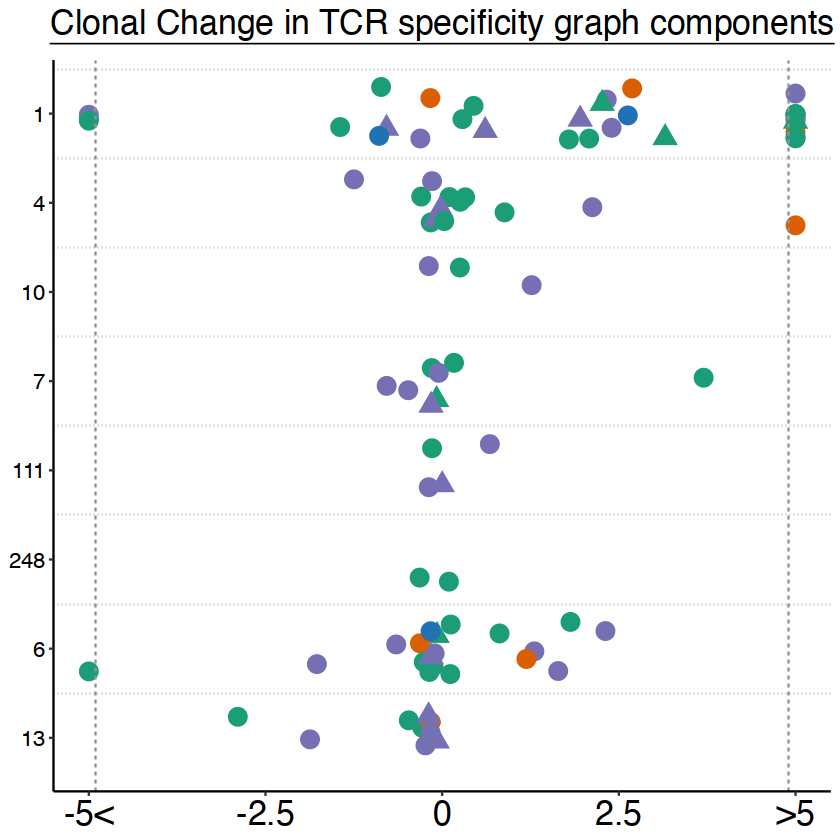

In [101]:
p4 #+ coord_cartesian(xlim = c(-5, 5) )

In [102]:
comppat_mat_unique <- comppat_mat_long[ !duplicated(comppat_mat_long$Component_id),]

In [ ]:
# p1 <- ggplot(comppat_mat_unique[which(comppat_mat_unique$MedianFisher < 0.001), ], 
# aes(x = Component_id, y = MedianFisher)) +
#   geom_bar(stat = "identity", width = 0.8, alpha = 1) +
#   coord_flip() +
#   scale_y_reverse() +
#   myplot +
#  theme( legend.position = "none",  plot.title = element_text(size = 20),
#    axis.text.y = element_blank(), axis.title.y = element_blank(), 
#    axis.ticks.y = element_blank(), axis.line.y = element_blank(),
#    axis.title.x = element_blank(), axis.text.x = element_text(angle = 30, size = 20, hjust = 1)
#  ) + ggtitle(expression(underline("Average specificity Fisher score"))) 


In [ ]:
# summary(comppat_mat_unique$MedianFisher)

In [ ]:
# p1

In [103]:
head(comppat_mat_unique)

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher
<dbl>,<fct>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>
7.10e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0,5.148742
5.60e-07,4,"CMV,HCV,HomoSapiens,HPV",CHP_396,129,Leukemia,HR ALL,0,6.251812
1.60e-06,5,"EBV,HomoSapiens,HPV",CHP_404,431,Solid tumors,ERMS,0,5.795880
1.10e-05,6,"CMV,EBV,HomoSapiens,HPV",CHP_396,977,Leukemia,HR ALL,0,4.958607
9.85e-06,7,"CMV,HomoSapiens",CHP_396,1910,Leukemia,HR ALL,0,5.006564
2.10e-05,8,,CHP_404,354,Solid tumors,ERMS,0,4.677781


In [104]:
mycomps <- comppat_mat_unique[which(comppat_mat_unique$Component_id %in% 
comppat_mat_long_summary_morethanone$Component_id), ]

In [105]:
mycomps$x <- 1

In [106]:
mycomps$Component_specificity[ mycomps$Component_specificity == ""] <- "Unknown"

In [107]:
head(mycomps)

MedianFisher,Component_id,Component_specificity,Patient,Delta,cancergroup,Disease,Relapse,log10MedianFisher,x
<dbl>,<fct>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>
7.10e-06,1,"CMV,EBV,HCV,HomoSapiens,HPV,InfluenzaM.tuberculosis,MCPyV,S-pneumoniae",CHP_396,30739,Leukemia,HR ALL,0,5.148742,1
5.60e-07,4,"CMV,HCV,HomoSapiens,HPV",CHP_396,129,Leukemia,HR ALL,0,6.251812,1
1.10e-05,6,"CMV,EBV,HomoSapiens,HPV",CHP_396,977,Leukemia,HR ALL,0,4.958607,1
9.85e-06,7,"CMV,HomoSapiens",CHP_396,1910,Leukemia,HR ALL,0,5.006564,1
8.35e-05,10,"EBV,HomoSapiens",CHP_404,705,Solid tumors,ERMS,0,4.078314,1
7.00e-05,13,"CMV,EBV,HPV",CHP_357,-62,Leukemia,AML,0,4.154902,1


In [108]:
mycomps$Component_specificity <- gsub("InfluenzaM.tuberculosis", "Influenza,M.tuberculosis", mycomps$Component_specificity)

In [109]:
text_plot <- ggplot(mycomps, aes(x = x, y = Component_id, label = Component_specificity)) +
  geom_text(size = 7) +
  myplot +
 theme(legend.position = "none", plot.title = element_text(size = 20),
   axis.text = element_blank(), axis.title = element_blank(), 
   axis.ticks = element_blank(), axis.line = element_blank()
 ) +
  ggtitle(expression(underline("Graph component annotations")))


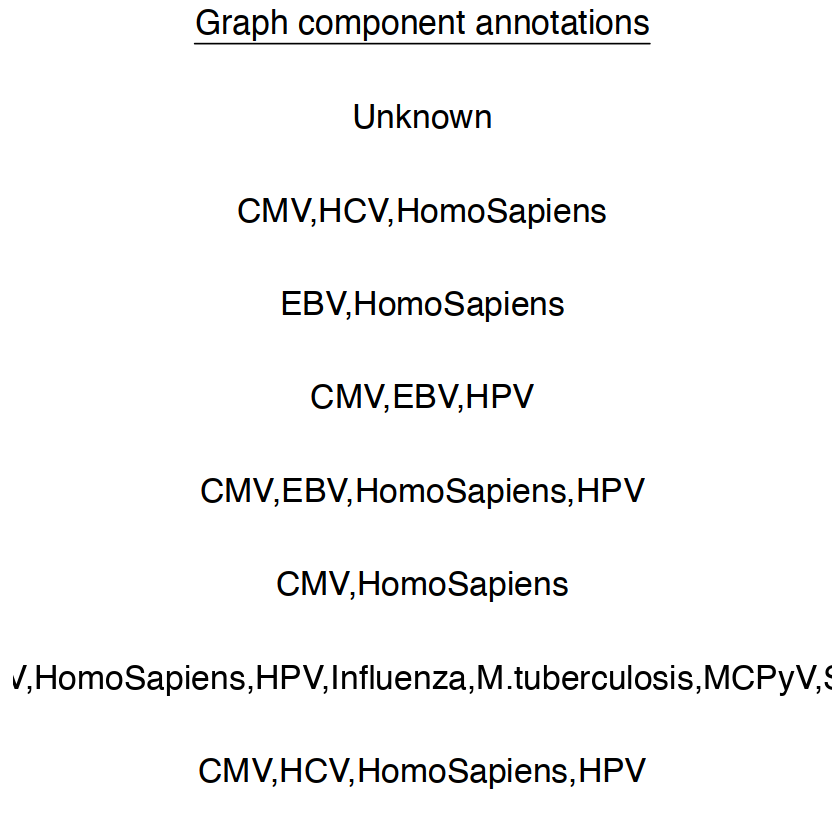

In [110]:
text_plot

In [ ]:
pdf(paste0(plotpath, "gliph_component_plot.pdf"), width = 14, height = 7)
cowplot::plot_grid(p4, text_plot,rel_widths = c(1, 0.4), labels = "D")
    # plot_layout(widths = c(1, 0.4))
dev.off()

## Compare INT and Emerson components in the joint anlaysis

In [14]:
int_emerson <- read.table(paste0(h4hpath, "v9_emerson_adult_child/manu_output/component_stats_emerson_adult_child_cdr3_gliph2.csv"), sep = ",", header = T)

In [15]:
int_emerson[ int_emerson$Component_id == 116,]

,Component_id,Component_size,PatientDerived_Nodes,NumberOf_PatientDerived_Nodes,Number_of_Patients,Component_specificity,KnownExternalTCRs
,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>
116,116,10,"CASSIVTAGGGYTF_Leukemia:CHP_411_X02-PBMC,CAWSKFIVTAKNIQYF_Lymphoma:CHP_371_X01-PBMC",2,2,"Leukemia,Lymphoma,MDavis",TBD


In [16]:
head(sort(int_emerson$Component_size, decreasing = T) )

[1] 43690   524   402   329   217   102

In [17]:
# remove the irrelevant component
int_emerson <- int_emerson[ int_emerson$Component_id != 1,]

In [18]:
# separate rows
int_emerson_sep <- tidyr::separate_rows(int_emerson, PatientDerived_Nodes, sep = ",")

In [19]:
int_emerson_sep$PatientDerived_Nodes[1000:1010]

[1] "CASSLGLAGASYEQYF_Solidtumors:CHP_404_X05-PBMC"
 [2] "CASSLGLAGDSYEQYF_AdultEmerson:P00018_2501"    
 [3] "CASSLGLAGGSYEQYF_AdultEmerson:P00251_23750"   
 [4] "CASSLGLAGTSYEQYF_AdultEmerson:P00022_4442"    
 [5] "CASSPGLAGYSYEQYF_Leukemia:CHP_382_X05-PBMC"   
 [6] "CASSVAGDEKLFF_AdultEmerson:P00458_43929"      
 [7] "CASSDYGALNTEAFF_Leukemia:CHP_376_X02-PBMC"    
 [8] "CASSLRGALNTEAFF_Leukemia:CHP_369_X02-cfDNA"   
 [9] "CASSPRGALNTEAFF_AdultEmerson:P00021_4149"     
[10] "CASSQDRDGQETQYF_AdultEmerson:P00457_43366"    
[11] "CASSQDRGGQETQYF_AdultEmerson:P00018_3186"

In [20]:
int_emerson_sep$cohort_cdr3 <- gsub(":.*", "", int_emerson_sep$PatientDerived_Nodes)
int_emerson_sep$cdr3 <- gsub("_.*", "", int_emerson_sep$cohort_cdr3)
int_emerson_sep$cohort <- gsub(".*_", "", int_emerson_sep$cohort_cdr3)

In [21]:
int_emerson_sep$basename <- gsub(".*:", "", int_emerson_sep$PatientDerived_Nodes)
int_emerson_sep$Patient <- NA
int_emerson_sep$Patient[!grepl("CHP", int_emerson_sep$basename)] <- gsub("_.*", "", int_emerson_sep$basename[!grepl("CHP", int_emerson_sep$basename)])
int_emerson_sep$Patient[grepl("CHP", int_emerson_sep$basename)] <- substr(int_emerson_sep$basename[grepl("CHP", int_emerson_sep$basename)], 1,7)
# int_emerson_sep$index <- gsub(".*_", "", int_emerson_sep$basename)

Add cloneCounts from gliphout

In [22]:
gliphout_adult <- readr::read_rds(file = paste0(datapath, "GLIPH/emerson_adult_cleaned.rds"))
gliphout_child <- readr::read_rds(file = paste0(datapath, "GLIPH/emerson_child_cleaned.rds"))
gliphout_int <- readr::read_rds(file = paste0(datapath, "GLIPH/int_gliph_v5_cleaned.rds"))

In [23]:
gliphout_adult$Sample <- gsub("Emerson", "AdultEmerson", gliphout_adult$Sample)
gliphout_child$Sample <- gsub("Emerson", "ChildEmerson", gliphout_child$Sample)

In [24]:
gliphout_all <- rbind( gliphout_adult, gliphout_child, gliphout_int)

In [25]:
gliphout_all$cdr3_sample <- paste(gliphout_all$TcRb, gliphout_all$Sample, sep = "_")

In [26]:
# add cloneCount
rowmatch <- match(int_emerson_sep$PatientDerived_Nodes, gliphout_all$cdr3_sample)
int_emerson_sep$cloneCount <- gliphout_all$Freq[rowmatch]

In [27]:
head(gliphout_all$cdr3_sample)

[1] "CASSLGTEQYF_MDavis:DRB10401"          
[2] "CASSLGAEAFF_MDavis:DRB10401"          
[3] "YASSLGGEQFF_MDavis:DRB10401"          
[4] "CASSLGVEQYF_AdultEmerson:P00014_2108" 
[5] "CASSLGYEAFF_AdultEmerson:P00486_45778"
[6] "CASSLGAEQYF_MDavis:DRB10401"

In [28]:
head(int_emerson_sep$PatientDerived_Nodes)

[1] "CASSEEEGGSYEQYF_AdultEmerson:P00639_63538"   
[2] "CASSEEEGGTGEQYF_Solidtumors:CHP_409_X02-PBMC"
[3] "CASSEEEGNEQFF_AdultEmerson:P00040_5855"      
[4] "CASSEEEGSGANVLTF_AdultEmerson:P00018_3056"   
[5] "CASSEEEGSNEKLFF_Leukemia:CHP_365_X04-PBMC"   
[6] "CASSEEEGTGNQPQHF_AdultEmerson:P00355_32489"

In [29]:
readr::write_rds(int_emerson_sep, file = paste0(datapath, "GLIPH/int_emerson_sep_counts.rds"))

Plot

In [30]:
cohort_comp_01 <- cohort_comp.fx(int_emerson_sep, "PBMC", "X01") 
cohort_comp_02 <- cohort_comp.fx(int_emerson_sep, "PBMC", "X02") 

In [31]:
# readr::write_rds(int_emerson_sep_x01, file = paste0(datapath, "GLIPH/components_sep_int_x01_pbmc_child_adult.rds"))

In [32]:
commoncomps1 <- rownames(cohort_comp_01)[ cohort_comp_01$grp == "Common"]
commoncomps2 <- rownames(cohort_comp_02)[ cohort_comp_02$grp == "Common"]

In [33]:
commoncomps2

[1] "2"   "3"   "4"   "5"   "9"   "11"  "12"  "19"  "21"  "26"  "33"  "40" 
[13] "71"  "75"  "76"  "77"  "78"  "87"  "91"  "92"  "100" "108" "113" "118"
[25] "119" "120" "121" "124" "125" "127" "128" "133" "134" "139" "140" "145"
[37] "146" "151" "153" "159" "163" "168" "174" "177" "188"

In [34]:
table(cohort_comp_01$grp)


     Adult     Cancer      Child     Common    Healthy   Leukemia   Lymphoma 
       112          2         11         42          2         17          6 
     Solid TcellMalig 
         5          1 

In [35]:
head(int_emerson_sep)

Component_id,Component_size,PatientDerived_Nodes,NumberOf_PatientDerived_Nodes,Number_of_Patients,Component_specificity,KnownExternalTCRs,cohort_cdr3,cdr3,cohort,basename,Patient,cloneCount
<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2,53,CASSEEEGGSYEQYF_AdultEmerson:P00639_63538,7,7,"AdultEmerson,Leukemia,MDavis,S-pneumoniae,Solidtumors",CASSEEEGQGKAGELFF_S-pneumoniae:NA_ECTGLAWEWWRTV,CASSEEEGGSYEQYF_AdultEmerson,CASSEEEGGSYEQYF,AdultEmerson,P00639_63538,P00639,139
2,53,CASSEEEGGTGEQYF_Solidtumors:CHP_409_X02-PBMC,7,7,"AdultEmerson,Leukemia,MDavis,S-pneumoniae,Solidtumors",CASSEEEGQGKAGELFF_S-pneumoniae:NA_ECTGLAWEWWRTV,CASSEEEGGTGEQYF_Solidtumors,CASSEEEGGTGEQYF,Solidtumors,CHP_409_X02-PBMC,CHP_409,15
2,53,CASSEEEGNEQFF_AdultEmerson:P00040_5855,7,7,"AdultEmerson,Leukemia,MDavis,S-pneumoniae,Solidtumors",CASSEEEGQGKAGELFF_S-pneumoniae:NA_ECTGLAWEWWRTV,CASSEEEGNEQFF_AdultEmerson,CASSEEEGNEQFF,AdultEmerson,P00040_5855,P00040,15
2,53,CASSEEEGSGANVLTF_AdultEmerson:P00018_3056,7,7,"AdultEmerson,Leukemia,MDavis,S-pneumoniae,Solidtumors",CASSEEEGQGKAGELFF_S-pneumoniae:NA_ECTGLAWEWWRTV,CASSEEEGSGANVLTF_AdultEmerson,CASSEEEGSGANVLTF,AdultEmerson,P00018_3056,P00018,121
2,53,CASSEEEGSNEKLFF_Leukemia:CHP_365_X04-PBMC,7,7,"AdultEmerson,Leukemia,MDavis,S-pneumoniae,Solidtumors",CASSEEEGQGKAGELFF_S-pneumoniae:NA_ECTGLAWEWWRTV,CASSEEEGSNEKLFF_Leukemia,CASSEEEGSNEKLFF,Leukemia,CHP_365_X04-PBMC,CHP_365,345
2,53,CASSEEEGTGNQPQHF_AdultEmerson:P00355_32489,7,7,"AdultEmerson,Leukemia,MDavis,S-pneumoniae,Solidtumors",CASSEEEGQGKAGELFF_S-pneumoniae:NA_ECTGLAWEWWRTV,CASSEEEGTGNQPQHF_AdultEmerson,CASSEEEGTGNQPQHF,AdultEmerson,P00355_32489,P00355,46


In [36]:
load(file = paste0(datapath, "Adaptivedatasets/allAdaptive.RData"))

In [37]:
head(meta_div)

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,basename,file,sampletype,Group,log10shann
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
287,CHP_10YO_M_00,CHP_10YO_M,X00,NA,NA,NA,Normal,NA,NA,NA,...,10.601,0.073,8.556,8.561,0.094,CHP_10YO-M_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_10YO-M_PBMC_DNA.txt,PBMC,CHP,1.0249370
288,CHP_11YO_M_00,CHP_11YO_M,X00,NA,NA,NA,Normal,NA,NA,NA,...,11.614,0.054,10.406,10.414,0.066,CHP_11YO-M_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_11YO-M_PBMC_DNA.txt,PBMC,CHP,1.0647200
289,CHP_15YO_F_A_00,CHP_15YO_F_A,X00,NA,NA,NA,Normal,NA,NA,NA,...,8.989,0.036,8.560,8.570,0.060,CHP_15YO-F-A_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-A_PBMC_DNA.txt,PBMC,CHP,0.9533731
290,CHP_15YO_F_B_00,CHP_15YO_F_B,X00,NA,NA,NA,Normal,NA,NA,NA,...,6.334,0.040,5.870,5.876,0.066,CHP_15YO-F-B_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-B_PBMC_DNA.txt,PBMC,CHP,0.8014037
291,CHP_15YO_M_00,CHP_15YO_M,X00,NA,NA,NA,Normal,NA,NA,NA,...,21.120,0.040,20.321,20.339,0.068,CHP_15YO-M_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-M_PBMC_DNA.txt,PBMC,CHP,1.3244882
292,CHP_16YO_M_00,CHP_16YO_M,X00,NA,NA,NA,Normal,NA,NA,NA,...,3.973,0.007,3.944,3.946,0.013,CHP_16YO-M_PBMC_DNA,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_16YO-M_PBMC_DNA.txt,PBMC,CHP,0.5990092


In [38]:
head(allAdaptive)

,sample_name,study,Agegroup,Sex,disease,subject,age
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,Preterm_23_3,Carey,Neonate,Male,Ctrl,Preterm_23_3,0
2,Preterm_25_5,Carey,Neonate,Female,Ctrl,Preterm_25_5,0
3,Preterm_26_B_2,Carey,Neonate,Male,Ctrl,Preterm_26_B_2,0
4,Preterm_27_4,Carey,Neonate,Female,Ctrl,Preterm_27_4,0
5,Adult_1_15-04,Carey,Adult,NA,Ctrl,Adult_1_15-04,39
6,Adult_2_15-07,Carey,Adult,NA,Ctrl,Adult_2_15-07,39


In [39]:
allAdaptive$Patient <- allAdaptive$sample_name
allAdaptive$Age <- allAdaptive$age

In [40]:
age_Adaptive_int <- rbind(meta_div[, c("Patient", "Age")], allAdaptive[, c("Patient", "Age")] )

In [41]:
pat_tab_1 <- comp_frac.fx(int_emerson_sep, "PBMC", "X01") 
pat_tab_2 <- comp_frac.fx(int_emerson_sep, "PBMC", "X02") 
pat_tab_3 <- comp_frac.fx(int_emerson_sep, "PBMC", "X03")
pat_tab_4 <- comp_frac.fx(int_emerson_sep, "PBMC", "X04") 
pat_tab_5 <- comp_frac.fx(int_emerson_sep, "PBMC", "X05")  

In [42]:
pat_tab_1$Age <- age_Adaptive_int$Age[match(rownames(pat_tab_1), age_Adaptive_int$Patient)]
pat_tab_2$Age <- age_Adaptive_int$Age[match(rownames(pat_tab_2), age_Adaptive_int$Patient)]

In [43]:
pat_tab_1$study <- pat_tab_1$cohort
pat_tab_1$study[grepl("Emerson", pat_tab_1$study)] <- "Healthy"

pat_tab_2$study <- pat_tab_2$cohort
pat_tab_2$study[grepl("Emerson", pat_tab_2$study)] <- "Healthy"

In [44]:
# int_emerson_sep[ int_emerson_sep$Patient == "CHP_346",]

In [45]:
dim(pat_tab_1)
dim(pat_tab_2)

[1] 247  19

[1] 254  19

In [46]:
table(pat_tab_1$cohort)
table(pat_tab_2$cohort)


      AdultEmerson       ChildEmerson           Leukemia           Lymphoma 
               200                 16                 16                  4 
       Solidtumors T-cellmalignancies 
                10                  1 


      AdultEmerson       ChildEmerson           Leukemia           Lymphoma 
               200                 16                 19                  5 
       Solidtumors T-cellmalignancies 
                12                  2 

In [47]:
pat_tab_1 <- pat_tab_1[ pat_tab_1$cohort != "T-cellmalignancies",]
pat_tab_2 <- pat_tab_2[ pat_tab_2$cohort != "T-cellmalignancies",]
pat_tab_3 <- pat_tab_3[ pat_tab_3$cohort != "T-cellmalignancies",]
pat_tab_4 <- pat_tab_4[ pat_tab_4$cohort != "T-cellmalignancies",]
pat_tab_5 <- pat_tab_5[ pat_tab_5$cohort != "T-cellmalignancies",]

In [48]:
head(pat_tab_1)

,AdultEmerson,ChildEmerson,Leukemia,Lymphoma,Solidtumors,T-cellmalignancies,cohort,total,CMV,EBV,HPV,HCV,HomoSapiens,MCPyV,Influenca,tuberculosis,pneumoniae,Age,study
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CHP_347,0,0,3,0,0,0,Leukemia,161,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.00000000,13,Leukemia
CHP_348,0,0,0,0,2,0,Solidtumors,23,0.86956522,0.00000000,0.86956522,0.00000000,0.00000000,0.00000000,0,0,0.00000000,18,Solidtumors
CHP_350,0,0,0,0,2,0,Solidtumors,29,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0,0,0.00000000,1,Solidtumors
CHP_357,0,0,4,0,0,0,Leukemia,131,0.21374046,0.00000000,0.00000000,0.05343511,0.05343511,0.16030534,0,0,0.00000000,1,Leukemia
CHP_362,0,0,0,0,3,0,Solidtumors,28,0.75000000,0.00000000,0.00000000,0.75000000,0.75000000,0.00000000,0,0,0.00000000,16,Solidtumors
CHP_363,0,0,0,0,15,0,Solidtumors,2127,0.07616361,0.05735778,0.05735778,0.06582040,0.12317819,0.06252938,0,0,0.05218618,20,Solidtumors


In [49]:
pat_tab_1m <- reshape2::melt(pat_tab_1[,c(19, 9:17)]) #study
pat_tab_2m <- reshape2::melt(pat_tab_2[,c(19, 9:17)]) # study
pat_tab_3m <- reshape2::melt(pat_tab_3[,c(7, 9:17)])
pat_tab_4m <- reshape2::melt(pat_tab_4[,c(6, 8:16)])
pat_tab_5m <- reshape2::melt(pat_tab_5[,c(7, 9:17)])

Using study as id variables

Using study as id variables

Using cohort as id variables

Using cohort as id variables

Using cohort as id variables



In [50]:
head(pat_tab_1m)

,study,variable,value
,<chr>,<fct>,<dbl>
1,Leukemia,CMV,0.00000000
2,Solidtumors,CMV,0.86956522
3,Solidtumors,CMV,0.00000000
4,Leukemia,CMV,0.21374046
5,Solidtumors,CMV,0.75000000
6,Solidtumors,CMV,0.07616361


In [51]:
pat_tab_1m$study[ pat_tab_1m$study == "Solidtumors"] <- "Solid tumors"
pat_tab_2m$study[ pat_tab_2m$study == "Solidtumors"] <- "Solid tumors"
pat_tab_3m$cohort[ pat_tab_3m$cohort == "Solidtumors"] <- "Solid tumors"
pat_tab_4m$cohort[ pat_tab_4m$cohort == "Solidtumors"] <- "Solid tumors"
pat_tab_5m$cohort[ pat_tab_5m$cohort == "Solidtumors"] <- "Solid tumors"

# pat_tab_m$cohort[ pat_tab_m$cohort == "T-cellmalignancies"] <- "T-cell malignancies"

In [52]:
group_col

Leukemia            Lymphoma        Solid tumors T-cell malignancies 
          "#1B9E77"           "#D95F02"           "#7570B3"           "#2171b5" 
                LFS              Normal 
            "black"        "light grey"

In [53]:
# group_col <- c(group_col, "white", "light grey")
names(group_col)[ names(group_col) == "Normal"] <- "Healthy"

In [54]:
# names(group_col)[8] <- c("AdultEmerson", "ChildEmerson")

In [55]:
table(pat_tab_1m$study)


     Healthy     Leukemia     Lymphoma Solid tumors 
        1944          144           36           90 

In [56]:
pat_tab_1m <- pat_tab_1m[! pat_tab_1m$variable %in% c("Influenca", "tuberculosis", "pneumoniae"),]
pat_tab_2m <- pat_tab_2m[! pat_tab_2m$variable %in% c("Influenca", "tuberculosis", "pneumoniae"),]
pat_tab_3m <- pat_tab_3m[! pat_tab_3m$variable %in% c("Influenca", "tuberculosis", "pneumoniae"),]
pat_tab_4m <- pat_tab_4m[! pat_tab_4m$variable %in% c("Influenca", "tuberculosis", "pneumoniae"),]
pat_tab_5m <- pat_tab_5m[! pat_tab_5m$variable %in% c("Influenca", "tuberculosis", "pneumoniae"),]

In [57]:
head(pat_tab_1m)

,study,variable,value
,<chr>,<fct>,<dbl>
1,Leukemia,CMV,0.00000000
2,Solid tumors,CMV,0.86956522
3,Solid tumors,CMV,0.00000000
4,Leukemia,CMV,0.21374046
5,Solid tumors,CMV,0.75000000
6,Solid tumors,CMV,0.07616361


In [58]:
comp_plot1 <- ggplot(data = pat_tab_1m, aes(x = variable, y = value, fill = study)) + 
geom_boxplot(outlier.color = NA, position = "dodge") + 
myplot + myaxis + 
theme(axis.title.x = element_blank()) +
 scale_fill_manual(values = group_col) +
#  geom_signif(annotation="0.04",y_position= 1.1, xmin= 4.7, xmax=5, textsize = 5, vjust = 0) + 
#  geom_signif(annotation="0.03",y_position= 1.1, xmin= 2.7, xmax=3, textsize = 5, vjust = 0) +
 ggtitle(~underline("Pre-therapy (n = 246)")) + 
labs(y = "TCR frequencies in components\nwith antigen annotation")

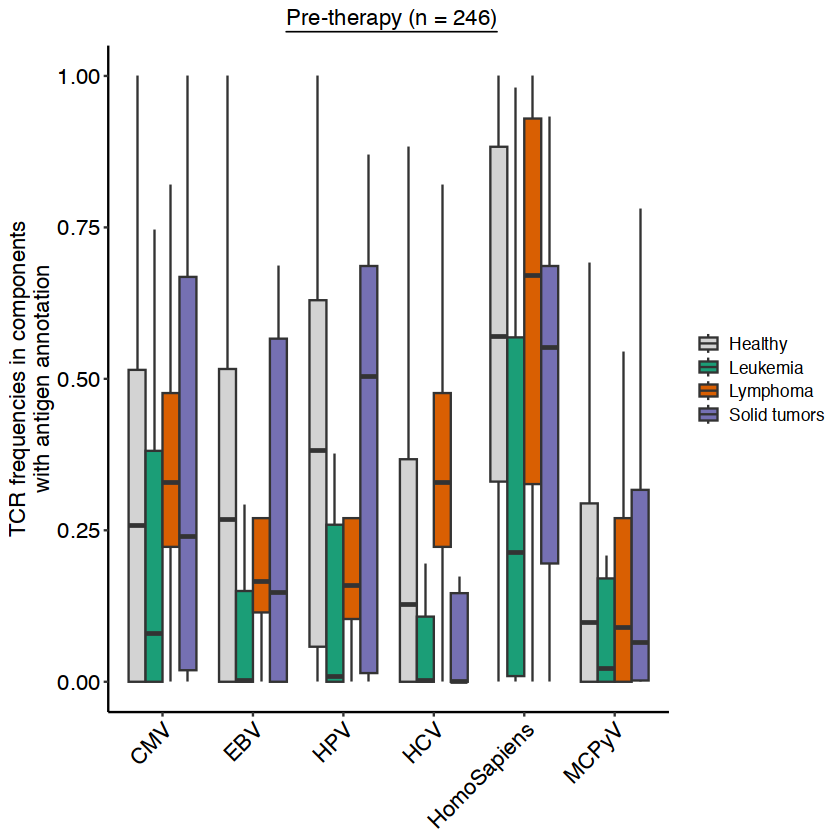

In [59]:
comp_plot1

In [60]:
comp_plot2 <- ggplot(data = pat_tab_2m, aes(x = variable, y = value, fill = study)) + 
geom_boxplot(outlier.color = NA, position = "dodge") + 
myplot + myaxis + 
theme(axis.title.x = element_blank()) +
 scale_fill_manual(values = group_col) +
# geom_signif(annotation="0.06",y_position= 1.05, xmin= 5.9, xmax=6., textsize = 5, vjust = 0) + 
# geom_signif(annotation="**",y_position= 0.3, xmin= 2.9, xmax=3.1, textsize = 10, vjust = 0.5) +
ggtitle(~underline("Pre-cycle 2 (n = 252)")) + 
labs(y = "TCR frequencies in components\nwith antigen annotation")

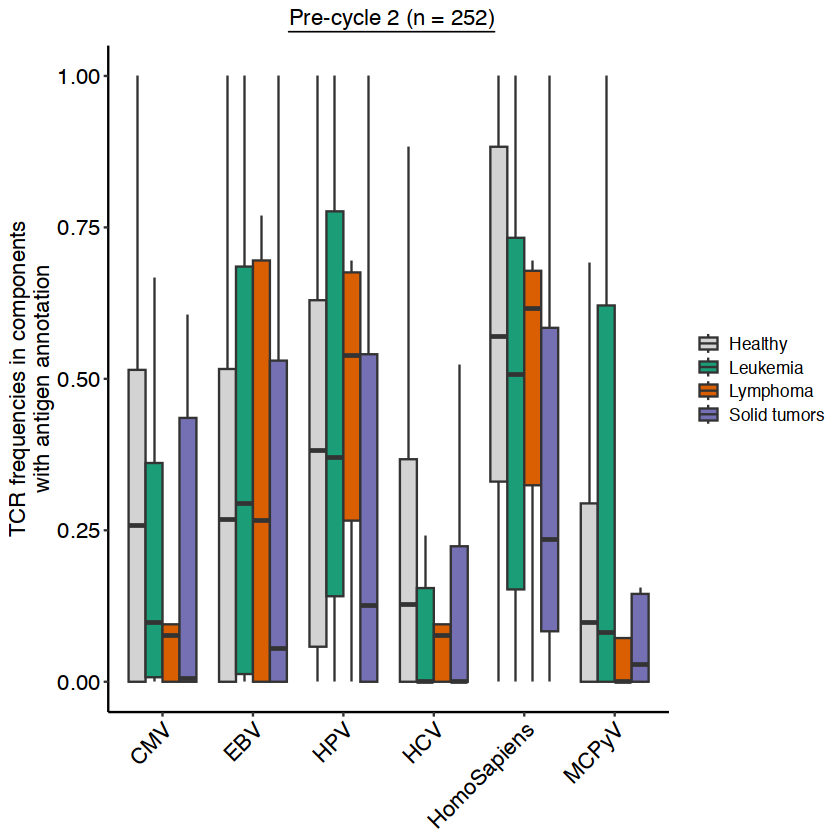

In [61]:
comp_plot2

In [62]:
# pat_tab <- pat_tab[ pat_tab$cohort != "T-cellmalignancies",]

In [63]:
tapply(pat_tab_1$HPV, pat_tab_1$study, summary)

$Healthy
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05785 0.38235 0.40306 0.62979 1.00000 

$Leukemia
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00947 0.15290 0.25921 0.86047 

$Lymphoma
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1036  0.1584  0.2153  0.2701  0.5446 

$Solidtumors
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.01434 0.50465 0.41084 0.68626 0.86957 


In [64]:
# tapply(pat_tab_1$HPV, pat_tab_1$cohort, summary)

In [65]:
myantigens <- c("CMV", "EBV", "Influenca", "HCV", "HPV", "MCPyV", "HomoSapiens")

In [66]:
table(pat_tab_1$cohort)


AdultEmerson ChildEmerson     Leukemia     Lymphoma  Solidtumors 
         200           16           16            4           10 

In [67]:
lmtest_mat <- as.data.frame(matrix(NA, nrow = 0, ncol = 6))
colnames(lmtest_mat) <- c("antigen", "group", "coefficient", "lower.95", "upper.95", "p")

In [68]:
for (i in myantigens) {
    print(i)
    myformula <- paste0(i, "~study+Age")
    myfit <- aov(as.formula(myformula), pat_tab_1)
suml <- summary.lm(myfit)
mymat <- as.data.frame(matrix(NA, nrow = 3, ncol = 6))
colnames(mymat) <- c("antigen", "group", "coefficient", "lower.95", "upper.95", "p")
mymat$antigen <- i
mymat$group <- rownames(suml$coefficients)[2:4]
mymat$coefficient <- suml$coefficients[2:4,1]
mymat$p <- suml$coefficients[2:4,4]

myCI <- confint(myfit, level = 0.95)
mymat$lower.95 <- myCI[2:4,1]
mymat$upper.95 <- myCI[2:4,2]

    lmtest_mat <- rbind(lmtest_mat, mymat)
}

[1] "CMV"
[1] "EBV"
[1] "Influenca"
[1] "HCV"
[1] "HPV"
[1] "MCPyV"
[1] "HomoSapiens"


In [69]:
# lmtest_mat

In [70]:
sig_lmtest_mat <- lmtest_mat[ which(lmtest_mat$p < 0.05),]
sig_lmtest_mat
sig_lmtest_mat$p.val <- sapply(sig_lmtest_mat$p, function(x) round_and_format(x) )

,antigen,group,coefficient,lower.95,upper.95,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
4,EBV,studyLeukemia,-0.2258954,-0.4270108,-0.02478004,0.02786545
13,HPV,studyLeukemia,-0.2481101,-0.4501435,-0.04607683,0.01629997


In [71]:
sig_lmtest_mat$study <- NA
sig_lmtest_mat$study <- gsub("study", "", sig_lmtest_mat$group)

In [72]:
comp_plot1 <- comp_plot1 + ggsignif::geom_signif(
            data = sig_lmtest_mat,
            aes(xmin = c(1.7,2.7), xmax = c(1.9,2.9), annotations = p.val, y_position = 1.1),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        )

Warning message in ggsignif::geom_signif(data = sig_lmtest_mat, aes(xmin = c(1.7, :
"Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position"


In [73]:
pdf(paste0(plotpath, "comp_plot_pbmc_x01.pdf"), width = 10, height = 5)
cowplot::plot_grid(comp_plot1, labels= "F")
dev.off()

pdf 
  2

In [74]:
lmtest_mat <- as.data.frame(matrix(NA, nrow = 0, ncol = 6))
colnames(lmtest_mat) <- c("antigen", "group", "coefficient", "lower.95", "upper.95", "p")

In [75]:
for (i in myantigens) {
    print(i)
    myformula <- paste0(i, "~study+Age")
    myfit <- aov(as.formula(myformula), pat_tab_2)
    suml <- summary.lm(myfit)
    mymat <- as.data.frame(matrix(NA, nrow = 3, ncol = 6))
    colnames(mymat) <- c("antigen", "group", "coefficient", "lower.95", "upper.95", "p")
    mymat$antigen <- i
    mymat$group <- rownames(suml$coefficients)[2:4]
    mymat$coefficient <- suml$coefficients[2:4, 1]
    mymat$p <- suml$coefficients[2:4, 4]

    myCI <- confint(myfit, level = 0.95)
    mymat$lower.95 <- myCI[2:4, 1]
    mymat$upper.95 <- myCI[2:4, 2]

    lmtest_mat <- rbind(lmtest_mat, mymat)
}


[1] "CMV"
[1] "EBV"
[1] "Influenca"
[1] "HCV"
[1] "HPV"
[1] "MCPyV"
[1] "HomoSapiens"


In [76]:
lmtest_mat

antigen,group,coefficient,lower.95,upper.95,p
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CMV,studyLeukemia,-0.06649750,-0.24259179,0.10959680,0.45771982
CMV,studyLymphoma,-0.06190987,-0.35273485,0.22891511,0.67537216
CMV,studySolidtumors,-0.09956393,-0.30576737,0.10663951,0.34252636
EBV,studyLeukemia,0.06937101,-0.12032612,0.25906813,0.47203656
EBV,studyLymphoma,0.02936075,-0.28392972,0.34265122,0.85370440
EBV,studySolidtumors,-0.06726207,-0.28939420,0.15487007,0.55145197
Influenca,studyLeukemia,0.00000000,0.00000000,0.00000000,NaN
Influenca,studyLymphoma,0.00000000,0.00000000,0.00000000,NaN
Influenca,studySolidtumors,0.00000000,0.00000000,0.00000000,NaN


In [77]:
sig_lmtest_mat <- lmtest_mat[ which(lmtest_mat$p < 0.06),]
sig_lmtest_mat
sig_lmtest_mat$p.val <- sapply(sig_lmtest_mat$p, function(x) round_and_format(x) )

,antigen,group,coefficient,lower.95,upper.95,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
16,MCPyV,studyLeukemia,0.1877709,0.03495265,0.3405892,0.01623845


In [78]:
sig_lmtest_mat$study <- NA
sig_lmtest_mat$study <- gsub("study", "", sig_lmtest_mat$group)

In [79]:
comp_plot2 <- comp_plot2 + ggsignif::geom_signif(
            data = sig_lmtest_mat,
            aes(xmin = 5.7, xmax = 5.9, annotations = p.val, y_position = 1.1),
            textsize = 3, vjust = -0.2, color = "black",
            manual = TRUE
        )

Warning message in ggsignif::geom_signif(data = sig_lmtest_mat, aes(xmin = 5.7, :
"Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position"


In [80]:
pdf(paste0(plotpath, "comp_plot_pbmc_x02.pdf"), width = 10, height = 5)
cowplot::plot_grid(comp_plot2, labels= "G")
dev.off()

pdf 
  2

In [198]:
tapply(pat_tab_2$HPV, pat_tab_2$study, summary)

$Healthy
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05785 0.38235 0.40306 0.62979 1.00000 

$Leukemia
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1412  0.3706  0.4666  0.7765  1.0000 

$Lymphoma
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2660  0.5385  0.4351  0.6757  0.6954 

$Solidtumors
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.1262  0.2728  0.5406  1.0000 


In [70]:
# pairwise.t.test(pat_tab_3$CMV, pat_tab_3$cohort, p.adjust.method = "bonferroni")
# pairwise.t.test(pat_tab_3$EBV, pat_tab_3$cohort, p.adjust.method = "bonferroni")
# pairwise.t.test(pat_tab_3$HPV, pat_tab_3$cohort, p.adjust.method = "bonferroni")
# pairwise.t.test(pat_tab_3$HCV, pat_tab_3$cohort, p.adjust.method = "bonferroni")
# pairwise.t.test(pat_tab_3$HomoSapiens, pat_tab_3$cohort, p.adjust.method = "bonferroni")
# pairwise.t.test(pat_tab_3$MCPyV, pat_tab_3$cohort, p.adjust.method = "bonferroni")

In [231]:
comp_all[ comp_all$Patient == "CHP_346", 1:6]

Component_id,Component_size,PatientDerived_Nodes,NumberOf_PatientDerived_Nodes,Number_of_Patients,Component_specificity
<int>,<int>,<chr>,<int>,<int>,<chr>
1,17492,CASSPNTGELFF_Solidtumors:CHP_346_X01-PBMC,8263,115,"CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies"
1,17492,CASSQDRGYGYTF_Solidtumors:CHP_346_X01-PBMC,8263,115,"CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies"
1,17492,CASSRDRGPYEQYF_Solidtumors:CHP_346_X01-PBMC,8263,115,"CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies"
1,17492,CASSRVGYEQYF_Solidtumors:CHP_346_X01-PBMC,8263,115,"CEF,CMV,EBV,HCV,HomoSapiens,HPV,Influenza,Leukemia,LFS,Lymphoma,M.tuberculosis,MCPyV,MDavis,Normal,S-pneumoniae,Solidtumors,T-cellmalignancies"


# Backup

Chi square

In [ ]:
#  
virals <- c("CMV", "EBV", "Influenza", "HCV", "HPV", "MCPyV")
int_emerson_sep_x01$viral <- NA
int_emerson_sep_x01$viral[ grep(paste(virals,collapse="|"), int_emerson_sep_x01$Component_specificity) ] <- 1

int_emerson_sep_x01$human <- NA
int_emerson_sep_x01$human[ grepl( "HomoSapiens", int_emerson_sep_x01$Component_specificity) ] <- 1

bacterials <- c("M.tuberculosis", "S-pneumoniae")
int_emerson_sep_x01$bacterial <- NA
int_emerson_sep_x01$bacterial[ grep(paste(bacterials,collapse="|"), int_emerson_sep_x01$Component_specificity) ] <- 1

int_emerson_sep_x01$multicancer <- NA
# if any two of the following are present, then multicancer
for(i in 1:nrow(int_emerson_sep_x01)){
    if( grepl("Leukemia", int_emerson_sep_x01$Component_specificity[i]) + grepl("Lymphoma", int_emerson_sep_x01$Component_specificity[i]) +
        grepl("T-cellmalignancies", int_emerson_sep_x01$Component_specificity[i]) + grepl("Solidtumors", int_emerson_sep_x01$Component_specificity[i])  > 1){
        int_emerson_sep_x01$multicancer[i] <- 1
    }
}

int_emerson_sep_x01$viral[is.na(int_emerson_sep_x01$viral)] <- 0
int_emerson_sep_x01$human[is.na(int_emerson_sep_x01$human)] <- 0
int_emerson_sep_x01$bacterial[is.na(int_emerson_sep_x01$bacterial)] <- 0
int_emerson_sep_x01$multicancer[is.na(int_emerson_sep_x01$multicancer)] <- 0

clonal fraction

In [ ]:
mysamples <- names(table(comp_all$Patient))

In [ ]:
length(mysamples)

[1] 311

In [ ]:
samples_compreads <- as.data.frame(matrix(0,
    nrow = length(mysamples), ncol = 5,
    dimnames = list(mysamples, c("Viral", "Bacterial", "Human", "Multicancer", "Crossreactive"))
))

In [ ]:
# add total reads in the original input files for gliph
gliphin_int <- readr::read_rds(file = paste0(datapath, "capTCRseq/INT_all_gliph_input_v2.rds"))
gliphin_adult <- readr::read_rds(paste0(h4hpath, "v9_emerson_adult/gliph_input/int_vdj_gliphinput_v9_emerson_adult.RDS"))
gliphin_child <- readr::read_rds(paste0(h4hpath, "v9_emerson_child/gliph_input/int_vdj_gliphinput_v9_emerson_child.RDS"))

In [ ]:
# group_by samplename, sum count
gliphin_int <- gliphin_int[ grepl("PBMC", gliphin_int$samplename),]
gliphin_int <- gliphin_int[ grepl("X01", gliphin_int$`subject:condition`),]
gliphin_int <- gliphin_int[ grepl("CHP", gliphin_int$`subject:condition`),]

gliphin_int_sum <- gliphin_int %>%
  group_by(samplename) %>%
  summarise(SumCount = sum(count), .groups = 'drop') %>%
  ungroup()

In [ ]:
gliphin_child <- gliphin_child[grepl("Emerson", gliphin_child$subject.condition), ]
gliphin_child$Patient <- gsub(".*:", "", gliphin_child$subject.condition)
gliphin_child$Patient <- gsub("_.*", "", gliphin_child$Patient)

gliphin_child_sum <- gliphin_child %>%
  group_by(Patient) %>%
  summarise(SumCount = sum(count), .groups = "drop") %>%
  ungroup()


In [ ]:
gliphin_adult <- gliphin_adult[ grepl("Emerson", gliphin_adult$subject.condition),]
gliphin_adult$Patient <- gsub(".*:", "", gliphin_adult$subject.condition)
gliphin_adult$Patient <- gsub("_.*", "", gliphin_adult$Patient)

gliphin_adult_sum <- gliphin_adult %>%
  group_by(Patient) %>%
  summarise(SumCount = sum(count), .groups = 'drop') %>%
  ungroup()

In [ ]:
gliphin_int_sum$Patient <- gsub("-01-.*", "", gliphin_int_sum$samplename)
gliphin_int_sum$Patient <- gsub("-01_.*", "", gliphin_int_sum$Patient)
gliphin_int_sum$Patient <- gsub("-", "_", gliphin_int_sum$Patient)

In [ ]:
gliphin_sum_all <- rbind(gliphin_int_sum[, c("Patient", "SumCount")], gliphin_child_sum, gliphin_adult_sum)

In [ ]:
# add total reads to samples_compreads
samples_compreads$cdr3_reads <- gliphin_sum_all$SumCount[match(rownames(samples_compreads), gliphin_sum_all$Patient)]

In [ ]:
head(samples_compreads)

,Viral,Bacterial,Human,Multicancer,Crossreactive,cdr3_reads
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP_346,0,0,0,0,0,988
CHP_347,0,0,0,0,0,5840
CHP_348,0,0,0,0,0,952
CHP_349,0,0,0,0,0,1035
CHP_350,0,0,0,0,0,1647
CHP_352,0,0,0,0,0,352


In [ ]:
temp <- comp_all[comp_all$viral == 1 & comp_all$bacterial == 0 & comp_all$human == 0, ]
comp_reads <- temp %>%
  group_by(Patient, viral) %>%
  summarise(SumCount = sum(cloneCount), .groups = "drop") %>%
  ungroup()
comp_reads <- comp_reads[comp_reads$viral == 1, ]
samples_compreads$Viral <- comp_reads$SumCount[match(rownames(samples_compreads), comp_reads$Patient)]


temp <- comp_all[comp_all$viral == 0 & comp_all$bacterial == 1 & comp_all$human == 0, ]
comp_reads <- temp %>%
  group_by(Patient, bacterial) %>%
  summarise(SumCount = sum(cloneCount), .groups = "drop") %>%
  ungroup()
comp_reads <- comp_reads[comp_reads$bacterial == 1, ]
samples_compreads$Bacterial <- comp_reads$SumCount[match(rownames(samples_compreads), comp_reads$Patient)]


temp <- comp_all[comp_all$viral == 0 & comp_all$bacterial == 0 & comp_all$human == 1, ]
comp_reads <- temp %>%
  group_by(Patient, human) %>%
  summarise(SumCount = sum(cloneCount), .groups = "drop") %>%
  ungroup()
comp_reads <- comp_reads[comp_reads$human == 1, ]
samples_compreads$Human <- comp_reads$SumCount[match(rownames(samples_compreads), comp_reads$Patient)]

# comp_reads <- comp_all %>%
#   group_by(Patient, multicancer) %>%
#   summarise(SumCount = sum(cloneCount), .groups = 'drop') %>%
#   ungroup()
# comp_reads <- comp_reads[ comp_reads$multicancer == 1,]
# samples_compreads$Multicancer <- comp_reads$SumCount[match(rownames(samples_compreads), comp_reads$Patient)]


In [ ]:
head(samples_compreads)

,Viral,Bacterial,Human,Multicancer,Crossreactive,cdr3_reads,cohort,frac
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
CHP_346,0,0,0,0,0,988,Solidtumors,0
CHP_347,57,0,0,0,0,5840,Leukemia,0
CHP_348,3,0,0,0,0,952,Solidtumors,0
CHP_349,0,0,0,0,0,1035,Leukemia,0
CHP_350,0,0,0,0,0,1647,Solidtumors,0
CHP_352,0,0,0,0,0,352,Leukemia,0


In [ ]:
# temp <- comp_all[ comp_all$Patient == "CHP_346", c("viral", "bacterial","cloneCount", "Component_id")]

In [ ]:
# add cohort to samples_compreads based on comp_all$cohort
samples_compreads$cohort <- comp_all$cohort[match(rownames(samples_compreads), comp_all$Patient)]


In [ ]:
tail(samples_compreads)

,Viral,Bacterial,Human,Multicancer,Crossreactive,cdr3_reads,cohort
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
P00647,NA,NA,NA,0,0,2715,Emerson_Adult
P00649,93,54,NA,0,0,41413,Emerson_Adult
P00650,NA,NA,NA,0,0,12858,Emerson_Adult
P00654,NA,NA,NA,0,0,14014,Emerson_Adult
P00656,107,NA,NA,0,0,31604,Emerson_Adult
P00665,NA,NA,NA,0,0,81794,Emerson_Adult


In [ ]:
# Replace NA values with 0 in columns
columns_to_fill <- colnames(samples_compreads)[1:5]
samples_compreads[columns_to_fill] <- lapply(samples_compreads[columns_to_fill], function(x) ifelse(is.na(x), 0, x))


In [ ]:
tail(samples_compreads)

,Viral,Bacterial,Human,Multicancer,Crossreactive,cdr3_reads,cohort
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
P00647,0,0,0,0,0,2715,Emerson_Adult
P00649,93,54,0,0,0,41413,Emerson_Adult
P00650,0,0,0,0,0,12858,Emerson_Adult
P00654,0,0,0,0,0,14014,Emerson_Adult
P00656,107,0,0,0,0,31604,Emerson_Adult
P00665,0,0,0,0,0,81794,Emerson_Adult


In [ ]:
table(comp_all$cohort)


     Emerson_Adult      Emerson_Child           Leukemia           Lymphoma 
             14746                754                973                208 
       Solidtumors T-cellmalignancies 
               579                 62 

In [ ]:
samples_compreads$frac <- samples_compreads$Viral / samples_compreads$cdr3_reads

In [ ]:
pairwise.t.test(samples_compreads$frac, samples_compreads$cohort,
    p.adjust.method = "bonferroni", pool.sd = FALSE
)



	Pairwise comparisons using t tests with non-pooled SD 

data:  samples_compreads$frac and samples_compreads$cohort 

                   Emerson_Adult Emerson_Child Leukemia Lymphoma Solidtumors
Emerson_Child      0.73          -             -        -        -          
Leukemia           1.00          1.00          -        -        -          
Lymphoma           1.00          1.00          1.00     -        -          
Solidtumors        1.00          1.00          1.00     1.00     -          
T-cellmalignancies 1.00          1.00          1.00     1.00     1.00       

P value adjustment method: bonferroni 

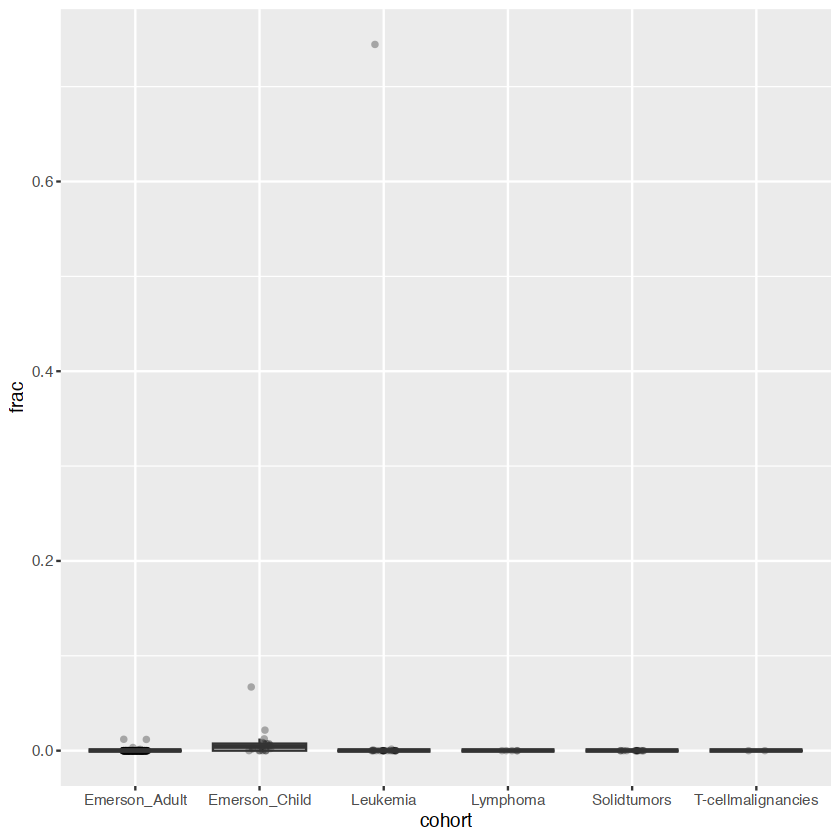

In [ ]:
ggplot(samples_compreads, aes(x = cohort, y = frac)) +
    geom_jitter(width = 0.1, alpha = 0.3, shape = 16) +
    geom_boxplot(fill = "transparent", outlier.shape = NA)

## Compare cfdna components with shbc

In [ ]:
components_cfdna <- readr::read_rds(file = paste0(datapath, "GLIPH/components_sep_cfDNA.rds"))